# Section1: Load Libraries

In [120]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from datetime import datetime
#!pip install pyod
from pyod.models.hbos import HBOS
from pyod.models.ecod import ECOD
from pyod.models.pca import PCA
#!pip install combo
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer

# Section2: Load Data

In [2]:
df = pd.read_csv('purchase_credit_card.csv')

In [3]:
df.head()

,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Description,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC)
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,SHERATON
2,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,07/29/2013 12:00:00 AM,07/31/2013 12:00:00 AM,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...
3,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,"GROCERY STORES,AND SUPERMARKETS"
4,201307,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,HAMMERMILL COPY PLUS COPY EA,125.96,STAPLES DIRECT,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT..."


In [4]:
# change column names 
df.columns = ['Year_Month', 'Agency_Number', 'Agency_Name', 'Cardholder_Last_Name',
      'Cardholder_First_Initial', 'Description', 'Amount', 'Vendor', 'Transaction_Date',
      'Posted_Date', 'Merchant_Category']

In [5]:
print(df.dtypes)

Year_Month                    int64
Agency_Number                 int64
Agency_Name                  object
Cardholder_Last_Name         object
Cardholder_First_Initial     object
Description                  object
Amount                      float64
Vendor                       object
Transaction_Date             object
Posted_Date                  object
Merchant_Category            object
dtype: object


In [29]:
#Converting Transaction_Date and Posted_date from Python Object data type to datetime
df['Transaction_Date']=pd.to_datetime(df['Transaction_Date'])
df['Posted_Date']=pd.to_datetime(df['Posted_Date'])
#Creating separate Year and Month columns for future feature engineering
df['Year_Month'].dtype
df['Year_Month']=pd.to_datetime(df['Year_Month'], format='%Y%m')
df['Year'] = df['Year_Month'].dt.year
df['Month'] = df['Year_Month'].dt.month
#Creating 'Week_Number' from 'Transaction_Date'
df['Week_Number'] = df['Transaction_Date'].dt.isocalendar().week

#Creating 'Day_of_Week' from 'Transaction_Date'
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
df['Day_of_Week'] = df['Transaction_Date'].dt.dayofweek.map(dayOfWeek)

df['Day_of_Week'].value_counts()

Wednesday    89644
Thursday     87537
Tuesday      86919
Friday       79917
Monday       61809
Saturday     26307
Sunday       10325
Name: Day_of_Week, dtype: int64

# Section3: HBOS

## Histogram-based Outlier Score (HBOS)
    It constructs histograms for variables and uses them to define the "outlier-ness" of the variables. For numerical variables, it is binned by values and for categorical variables, it is binned by counts. While the maximum height of each histogram is normalized to 1, observations that do not belong to a bin with large height values may be potential anomalies.

## 3.1: Build Model

In [25]:
# Set up model
n_bins = 1000
hbos = HBOS(n_bins=n_bins,contamination=0.05)


## 3.2: Summary Statistics

In [26]:
def descriptive_stat_threshold(df, pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    data = df.copy()
    data['Anomaly_Score'] = pred_score
    data['Group'] = np.where(data['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = data.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = data.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)


The table shows the characteristics of the normal and abnormal groups. The “Anomaly_Score” is the average anomaly score, large difference of this score verifies the data in the outlier group are outliers.

## 3.3: Aggregated Average

In [27]:
def norm_scores(feature):
    feature = pd.DataFrame(feature)
    # Standardize data
    feature_norm = standardizer(feature)

    # Test a range of binning 
    k_list = [5, 10, 15, 20, 25, 30, 50, 60, 75, 100]
    n_clf = len(k_list)
    # Just prepare data frames so we can store the model results
    feature_scores = np.zeros([feature.shape[0], n_clf])

    # Modeling
    for i in range(n_clf):
        k = k_list[i]
        hbos = HBOS(n_bins=n_bins)
        hbos.fit(feature_norm)
        # Store the results in each column:
        feature_scores[:, i] = hbos.decision_function(feature_norm) 
    # Decision scores have to be normalized before combination
    scores_norm = standardizer(feature_scores)
    
    # Combination by average
    # The scores_norm is 500 x 10. The "average" function will take the average of the 10 columns. The result "y_by_average" is a single column: 
    feature_by_average = average(scores_norm)
    plt.hist(feature_by_average, bins='auto') # arguments are passed to np.histogram
    plt.title("Combination by average")
    plt.show()


Stable outcomes can be produced by building HBOS models with a range of histogram widths to obtain multiple scores then aggregate the scores. It can help avoid overfitting and increase the prediction accuracy. The feature will be normalized before aggregating. The average method with 10 HBOS bins will be used in the following report.

# Section4: Features

## Feature 1: The ratio to average (Agent_Name, Marchant_Category)

In [32]:
# create average spending group by agency and merchant category 
stat_by_agency = df.groupby(['Agency_Name', 'Merchant_Category'])['Amount'].mean()
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['AVG_amount']
stat_by_agency

AVG_amount
Agency_Name                     Merchant_Category                                     
ARDMORE HIGHER EDUCATION CENTER BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED  115.120000
                                CATALOG MERCHANTS                           -53.344286
                                COMPUTER NETWORK/INFORMATION SERVICES        18.340000
                                DRUG STORES AND PHARMACIES                  153.450000
                                GROCERY STORES,AND SUPERMARKETS              74.525455
...                                                                                ...
`DEPARTMENT OF EDUCATION        TELECOMMUNICATION SERVICES                  118.054000
                                TRAVEL AGENCIES                              24.253731
                                TROPICANA RESORT AND CASINO                 481.600000
                                UNITED AIRLINES                             310.547368
                                WYNDHAM HOTELS                               93.282857

[8427 rows x 1 columns]

In [34]:
# add the new feature average spending to the dataset 
df1 = pd.merge(df, stat_by_agency, how='left', on=['Agency_Name', 'Merchant_Category'])
# Feature 1: ratio of amount spending and average spending by merchant category 
df1['agency_merchant_avg_ratio_amount'] = np.where(df1['AVG_amount']==0,0, df1['Amount'] / df1['AVG_amount'])
df1.head(5)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,AVG_amount,agency_merchant_avg_ratio_amount
0,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,2013-07-30,2013-07-31,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,2013,7,31,Tuesday,427.634060,2.081219
1,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,2013-07-30,2013-07-31,SHERATON,2013,7,31,Tuesday,378.629890,0.974461
2,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,2013-07-29,2013-07-31,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...,2013,7,31,Monday,392.459376,0.422515
3,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,2013-07-30,2013-07-31,"GROCERY STORES,AND SUPERMARKETS",2013,7,31,Tuesday,59.832149,1.611007
4,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,HAMMERMILL COPY PLUS COPY EA,125.96,STAPLES DIRECT,2013-07-30,2013-07-31,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT...",2013,7,31,Tuesday,271.213133,0.464432


<AxesSubplot:xlabel='agency_merchant_avg_ratio_amount'>

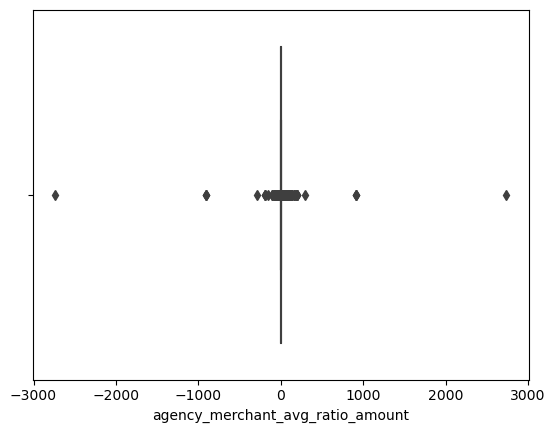

In [35]:
sns.boxplot(x = 'agency_merchant_avg_ratio_amount', data = df1) 

In [36]:
x1=pd.DataFrame(df1['agency_merchant_avg_ratio_amount'])
# fit HBOS model
hbos.fit(x1)

# find threshold using built-in function
thres1=hbos.threshold_
print("The threshold for the defined contamination rate:" , thres1)

The threshold for the defined contamination rate: 3.2401655799377465


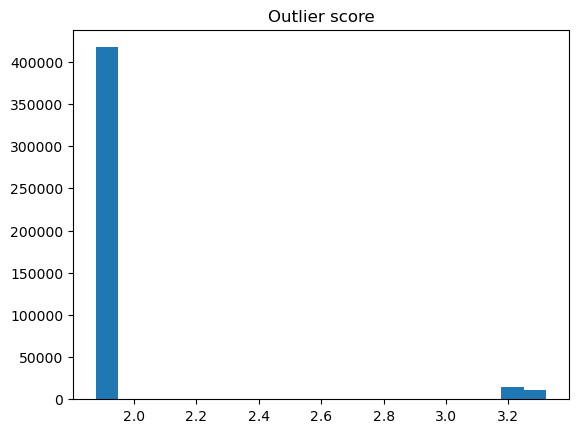

In [16]:
# threshold using histogram of the PCA outlier score
scores1 = hbos.decision_function(x1)
plt.hist(scores1, bins='auto') # arguments are passed to np.histogram
plt.title("Outlier score")
plt.show()

In [37]:
# find outliers based on the threshold
descriptive_stat_threshold(x1, scores1, thres1)

,Group,Count,Count %,agency_merchant_avg_ratio_amount,Anomaly_Score
0,Normal,417119,94.273129,0.82,1.88
1,Outlier,25339,5.726871,3.99,3.26


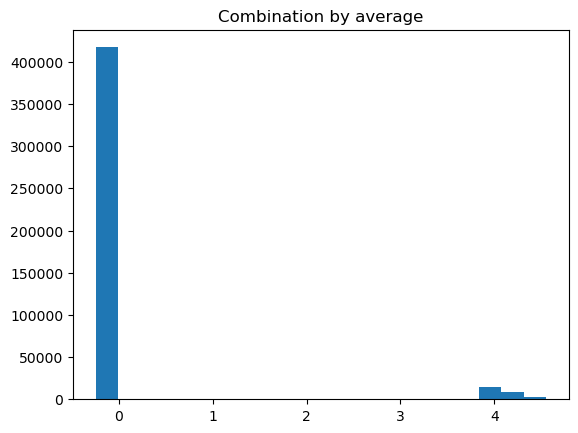

In [38]:
# fit aggregated average and plot
norm_scores(x1)

Summary:  
    Solely looking at the amount by Agent_Name and Marchant_Category, we can find out some anomalies. Grouped by Agent_Name Marchant_Category with extreme amount need more attention, since they are charging more frequently than average. 
    Based on the threshold calculated by the HBOS which is 3.24, the descriptive statistics shows 25339 anomalies, around 5.7%. The large difference in anomaly score verifies the data in the outlier group are outliers.

## Feature2: The ratio to median amount (Agent_Name, Marchant_Category)

In [67]:
# create average spending group by agency and merchant category 
stat_by_agency = df.groupby(['Agency_Name', 'Merchant_Category'])['Amount'].median() 
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['Median_amount']

In [70]:
# add the new feature average spending to the dataset 
df2 = pd.merge(df, stat_by_agency, how='left', on=['Agency_Name', 'Merchant_Category'])
# Feature 1: ratio of amount spending and avergae spending by merchant category 
df2['agency_merchant_median_ratio_amount'] = np.where(df2['Median_amount']==0,0, df2['Amount'] / df2['Median_amount'])
df2.head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,Median_amount,agency_merchant_median_ratio_amount
0,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,2013-07-30,2013-07-31,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,2013,7,31,Tuesday,250.000,3.560000
1,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,2013-07-30,2013-07-31,SHERATON,2013,7,31,Tuesday,262.090,1.407761
2,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,2013-07-29,2013-07-31,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...,2013,7,31,Monday,171.510,0.966824
3,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,2013-07-30,2013-07-31,"GROCERY STORES,AND SUPERMARKETS",2013,7,31,Tuesday,32.485,2.967216
4,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,HAMMERMILL COPY PLUS COPY EA,125.96,STAPLES DIRECT,2013-07-30,2013-07-31,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT...",2013,7,31,Tuesday,110.115,1.143895


In [73]:
df2['agency_merchant_median_ratio_amount'].describe()

count    442458.000000
mean          4.952685
std        1078.581350
min       -1003.176471
25%           0.466090
50%           1.000000
75%           2.121102
max      528116.052705
Name: agency_merchant_median_ratio_amount, dtype: float64

<AxesSubplot:xlabel='agency_merchant_median_ratio_amount'>

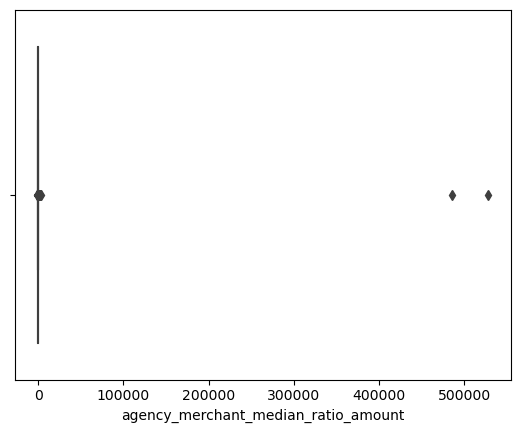

In [74]:
sns.boxplot(x = 'agency_merchant_median_ratio_amount', data = df2) 

In [114]:
# Reset up model
n_bins = 10000
hbos = HBOS(n_bins=n_bins,contamination=0.05)

In [115]:
x2=pd.DataFrame(df2['agency_merchant_median_ratio_amount'])
# fit HBOS model
hbos.fit(x2)

# find threshold using built-in function
thres2=hbos.threshold_
print("The threshold for the defined contamination rate:" , thres2)

The threshold for the defined contamination rate: 3.2569627642450554


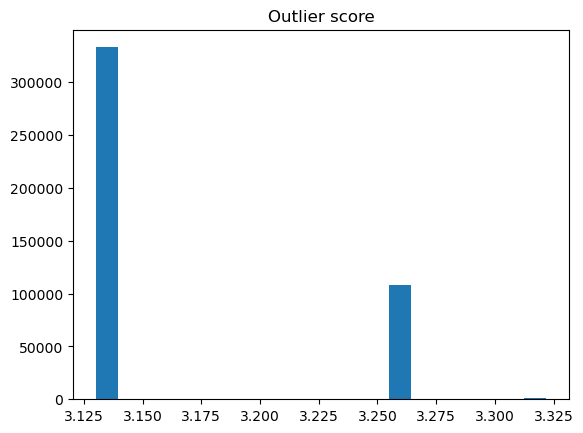

In [116]:
# threshold using histogram of the PCA outlier score
scores2 = hbos.decision_function(x2)
plt.hist(scores2, bins='auto') # arguments are passed to np.histogram
plt.title("Outlier score")
plt.show()

In [117]:
# find outliers based on the threshold
descriptive_stat_threshold(x2, scores2, thres2)

,Group,Count,Count %,agency_merchant_median_ratio_amount,Anomaly_Score
0,Normal,333187,75.303645,0.73,3.13
1,Outlier,109271,24.696355,17.84,3.26


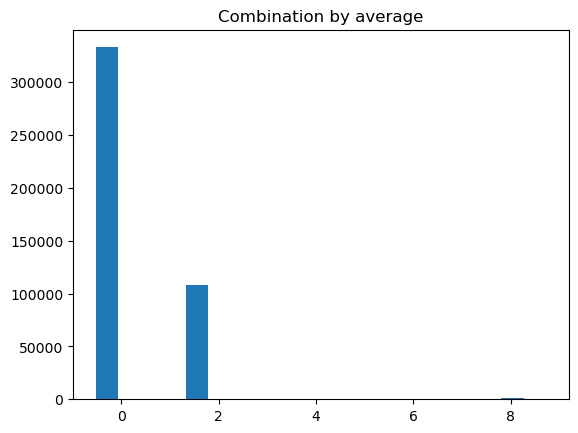

In [132]:
# fit aggregated average and plot
norm_scores(x2)

Summary:

Summary:
    This is a very interesting experience, which just changed mean to median but the result shows the difference. Originally, I use the same bin size of 1000, but it shows 100% outliers so I have to change the bin size to 10000 (I encountered the same issue in the feature 1 which the first attempt with bin size of 50 produced 100% outliers until I changed the bin size to 1000), and the result shows there are 109271 outliers which represents 24.69% of dataset. Therefore, the attention has to be rasied for using HBOS with the bin size.

# Section5: ECOD
    ECOD uses the skewness of distribution to assign the outlier score for a dimension. Then it aggregates the univariate outlier scores across all dimensions to get the overall outlier score for an observation. It derives the cumulative distribution empirically for a variable.

## 5.1: Build Model

In [121]:
# Set up ECOD model
ecod = ECOD(contamination=0.05)

## Section 5.2 Summary Statistics

In [122]:
def descriptive_stat_threshold(df, pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    data = df.copy()
    data['Anomaly_Score'] = pred_score
    data['Group'] = np.where(data['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = data.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = data.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

The table shows the characteristics of the normal and abnormal groups. The “Anomaly_Score” is the average anomaly score, large difference of this score verifies the data in the outlier group are outliers.

## Feature 3: Feature1 with ECOD model

In [126]:
##### fit ECOD model #####
ecod = ECOD(contamination=0.05)
ecod1=ecod.fit(x1)

# find threshold using built-in function
print("The threshold for the ECOD defined contamination rate:" , ecod1.threshold_)

The threshold for the ECOD defined contamination rate: 3.6888297331165227


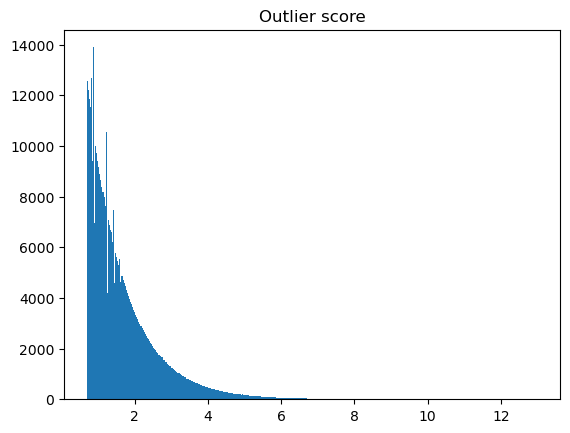

In [124]:
# threshold using histogram of the ECOD outlier score
plt.hist(ecod1.decision_function(x1), bins='auto') # arguments are passed to np.histogram
plt.title("Outlier score")
plt.show()

In [125]:
# find outliers based on the ECOD threshold
descriptive_stat_threshold(x1, ecod1.decision_function(x1), ecod1.threshold_)

,Group,Count,Count %,agency_merchant_avg_ratio_amount,Anomaly_Score
0,Normal,420334,94.999751,0.81,1.54
1,Outlier,22124,5.000249,4.64,4.69


Summary:
    Solely looking at the amount by Agent_Name and Marchant_Category, we can find out some anomalies. Grouped by Agent_Name Marchant_Category with extreme amount need more attention, since they are charging more frequently than average. 
    Based on the threshold calculated by the ECOD which is 3.68, the descriptive statistics shows 22124 anomalies, around 5%. The large difference in anomaly score verifies the data in the outlier group are outliers. Also, compared to HBOS method, it shows less outliers.

## Feature 4: Feature2 with ECOD model

In [130]:
##### fit ECOD model #####
ecod = ECOD(contamination=0.05)
ecod2=ecod.fit(x2)

# find threshold using built-in function
print("The threshold for the ECOD defined contamination rate:" , ecod2.threshold_)

The threshold for the ECOD defined contamination rate: 3.6888297331165227


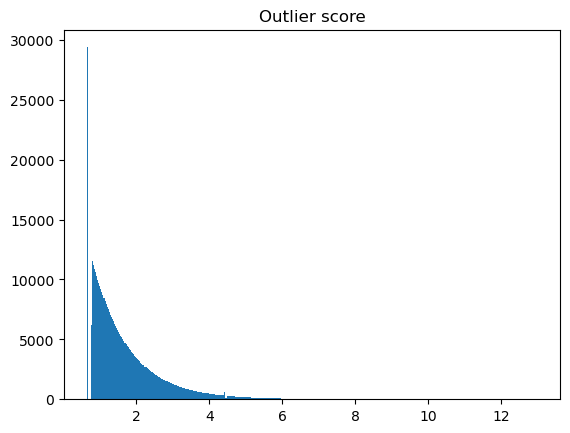

In [131]:
# threshold using histogram of the ECOD outlier score
plt.hist(ecod2.decision_function(x2), bins='auto') # arguments are passed to np.histogram
plt.title("Outlier score")
plt.show()

In [129]:
# find outliers based on the ECOD threshold
descriptive_stat_threshold(x2, ecod2.decision_function(x2), ecod2.threshold_)

,Group,Count,Count %,agency_merchant_median_ratio_amount,Anomaly_Score
0,Normal,420334,94.999751,1.81,1.53
1,Outlier,22124,5.000249,64.57,4.69


Summary:
    This shows a very interesting result, which it works really well with 5% outliers compared to the feature 2 (In feature2, it shows 25% outliers) which the features are the same but different anomaly detection method(HBOS vs ECOD). In ECOD, the threshold is set at 3.688 and there are 22124 outliers which is the same as feature 3.